https://mp.weixin.qq.com/s?__biz=MzIwODI2NDkxNQ==&mid=2247491108&idx=4&sn=83cc848c8c135d42de3aed13f11bec2a&chksm=97049598a0731c8edd04b4b608e77b39779a57efd45f28f89f2eccc8b7d7a760ba6704257378&scene=126&sessionid=1602301314&key=5e7686a5aca6468b618bcb1f6c262c3f3c4b233665027f982d92d0a16b8a2f131d5bd61abc680552ca3de8fdfe28207b50575c056a16d3caa31a14208adcbf49a61c1328e33ba421306476d5d8341b10c14529fce060d50f62f08e034aeb0b202f10ef71430f0d645610ee2f5a061bbbbec784d4018e51bbb6a2fbe09f3eb24a&ascene=1&uin=MjA1MjAyODkxNg%3D%3D&devicetype=Windows+10+x64&version=6300002f&lang=zh_CN&exportkey=AS%2BHfW2LmxMlbbgu1pb%2FrSM%3D&pass_ticket=r73dN6WAoU34njH2Itmau7OCgfMAc%2B%2B6UUeo0VP0x2FaTcNbgQOBYzN4LDC9tS0p&wx_header=0

In [1]:
import tensorflow as tf

#### 1.tf.data构建输入管道

In [2]:
dataset = tf.data.Dataset.from_tensor_slices([8,3,0,8,2,1])

In [3]:
iter(dataset).next().numpy()

8

In [6]:
# 构建Batch并打乱
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1]).shuffle(6)

In [7]:
iter(dataset).next().numpy()

1

In [8]:
# Batch
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1]).batch(2)
iter(dataset).next().numpy()

array([8, 3])

In [9]:
# Shuffle and Batch
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1]).shuffle(6).batch(2)
iter(dataset).next().numpy()

array([2, 8])

In [10]:
# 把两个Datasets压缩成一个
dataset0 = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset1 = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6])
dataset = tf.data.Dataset.zip((dataset0,dataset1))
iter(dataset).next()

(<tf.Tensor: shape=(), dtype=int32, numpy=8>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>)

In [12]:
# 映射外部函数
def into_2(num):
    return num * 2
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1]).map(into_2)
iter(dataset).next().numpy()

16

#### ImageDataGenerator

#### 2.使用tf.image做数据增强

In [3]:
image = tf.io.read_file('../../dataset/cat.png')

In [5]:
image = tf.image.decode_png(image)

In [8]:
flipped = tf.image.flip_left_right(image)

In [10]:
import matplotlib.pyplot as plt

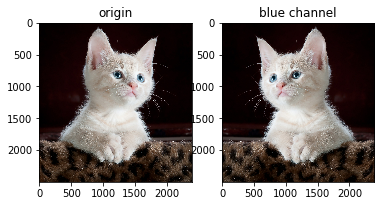

In [15]:
plt.subplot(1,2,1)
plt.title('origin')
plt.imshow(image)

plt.subplot(1,2,2)
plt.title('blue channel')
plt.imshow(flipped)

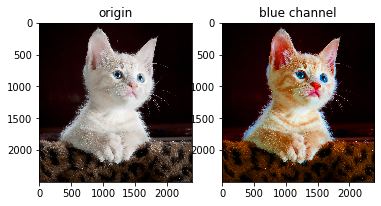

In [16]:
saturated = tf.image.adjust_saturation(image,5)
plt.subplot(1,2,1)
plt.title('origin')
plt.imshow(image)

plt.subplot(1,2,2)
plt.title('blue channel')
plt.imshow(saturated)

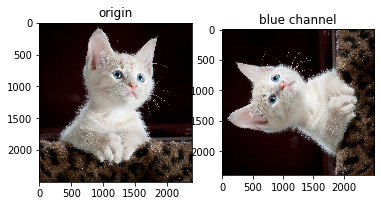

In [17]:
rotated = tf.image.rot90(image)
plt.subplot(1,2,1)
plt.title('origin')
plt.imshow(image)

plt.subplot(1,2,2)
plt.title('blue channel')
plt.imshow(rotated)

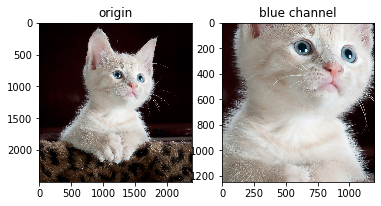

In [18]:
cropped = tf.image.central_crop(image,central_fraction=0.5)
plt.subplot(1,2,1)
plt.title('origin')
plt.imshow(image)

plt.subplot(1,2,2)
plt.title('blue channel')
plt.imshow(cropped)

#### 3.Tensorflow Datasets

#### 4.使用预训练模型进行迁移学习

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

In [ ]:
# 这个base_model可以很容易地通过额外的层或不同的模型进行扩展，如：
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

#### 5.Estimators

In [ ]:
linear_est = tf.estimator.LinearClassifier(
    feature_columns=feature_columns
)

linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

#### 6.自定义层

In [ ]:
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(CustomDense, self).__init__()
        self.num_outputs = num_outputs

    def build(self, input_shape):
        self.kernel = self.add_weight(
            "kernel",
            shape=[int(input_shape[-1]),
            self.num_outputs]
        )
    def call(self, input):
        return tf.matmul(input, self.kernel)

#### 7.自定义训练

In [ ]:
def train(model,inputs,outputs,learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(outputs,model(inputs))
    # Gradients for Trainable Variables with Obtained Losses  
    dW, db = t.gradient(current_loss, [model.W, model.b])
    # Applying Gradients to Weights
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

#### 8.Checkpoints

In [ ]:
# 保存Checkpoint
checkpoint_path = “save_path”

# Defining a Checkpoint
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)

# Creating a CheckpointManager Object
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Saving a Model
ckpt_manager.save()
# 从Checkpoint加载模型
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)

#### 9.Keras Tuner

#### 10.分布式训练

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(
            32, 3, activation='relu',  input_shape=(28, 28, 1)
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10)
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=['accuracy']
    )